In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Download the data.
!unzip /content/drive/MyDrive/SMAI.zip -d /content/SMAI



Streaming output truncated to the last 5000 lines.
  inflating: /content/SMAI/content/faces_dataset/train/image_5499.jpg  
  inflating: /content/SMAI/content/faces_dataset/train/image_55.jpg  
  inflating: /content/SMAI/content/faces_dataset/train/image_550.jpg  
  inflating: /content/SMAI/content/faces_dataset/train/image_5500.jpg  
  inflating: /content/SMAI/content/faces_dataset/train/image_5501.jpg  
  inflating: /content/SMAI/content/faces_dataset/train/image_5502.jpg  
  inflating: /content/SMAI/content/faces_dataset/train/image_5503.jpg  
  inflating: /content/SMAI/content/faces_dataset/train/image_5504.jpg  
  inflating: /content/SMAI/content/faces_dataset/train/image_5505.jpg  
  inflating: /content/SMAI/content/faces_dataset/train/image_5506.jpg  
  inflating: /content/SMAI/content/faces_dataset/train/image_5507.jpg  
  inflating: /content/SMAI/content/faces_dataset/train/image_5508.jpg  
  inflating: /content/SMAI/content/faces_dataset/train/image_5509.jpg  
  inflating: /co

- vision transfomer, prefer adamW --priority
- See the images after resizing may be quality is going down
- resnet-100 can be tried
- try uniforming the data if possivle
- try boosting ...
- gaussian blur in augmentation
-




In [ ]:
import numpy as np
import pandas as pd
from glob import glob
from os.path import join
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
import torch.optim as optim

from torchvision.transforms import RandomRotation, RandomHorizontalFlip, RandomResizedCrop,GaussianBlur


class AgeDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, annot_path, train=True):
        super(AgeDataset, self).__init__()

        self.annot_path = annot_path
        self.data_path = data_path
        self.train = train

        self.ann = pd.read_csv(annot_path)
        if train:
            # Calculate the frequency of each age
            age_counts = self.ann['age'].value_counts()
            age_counts = self.ann['age'].value_counts().head(50)

            # Calculate the average number of samples per age
            threshold = int(age_counts.mean())

            # Find the ages that are overrepresented
            overrepresented_ages = age_counts[age_counts > threshold].index

            # Remove random samples from overrepresented ages
            for age in overrepresented_ages:
                over_samples = self.ann[(self.ann['age'] == age)]
                drop_indices = np.random.choice(over_samples.index, size=(len(over_samples) - threshold), replace=False)
                self.ann = self.ann.drop(drop_indices)

            # Reset the index after dropping rows
            self.ann.reset_index(drop=True, inplace=True)

        self.files = self.ann['file_id']
        if train:
            self.ages = self.ann['age']
        self.transform = self._transform(224)

    @staticmethod
    def _convert_image_to_rgb(image):
        return image.convert("RGB")


    def _transform(self, n_px):
        if self.train:
            # Data augmentation for training
            transform = Compose([
                RandomRotation(degrees=15),
                RandomResizedCrop(size=n_px,
                                  scale=(0.8, 1.0)),
                RandomHorizontalFlip(),
                Resize(n_px),
                GaussianBlur(kernel_size=3),
                self._convert_image_to_rgb,
                ToTensor(),
                Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
            ])
        else:
            # Validation/test transformation
            transform = Compose([
                Resize(n_px),
                self._convert_image_to_rgb,
                ToTensor(),
                Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
            ])
        return transform

    def read_img(self, file_name):
        im_path = join(self.data_path, file_name)
        img = Image.open(im_path)
        img = self.transform(img)
        return img

    def __getitem__(self, index):
        file_name = self.files[index]
        img = self.read_img(file_name)
        if self.train:
            age = self.ages[index]
            return img, age
        else:
            return img

    def __len__(self):
        return len(self.files)



train_path = '/content/SMAI/content/faces_dataset/train'
train_ann = '/content/SMAI/content/faces_dataset/train.csv'
train_dataset = AgeDataset(train_path, train_ann, train=True)


test_path = '/content/SMAI/content/faces_dataset/test'
test_ann = '/content/SMAI/content/faces_dataset/submission.csv'
test_dataset = AgeDataset(test_path, test_ann, train=False)


test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)
train_indices, val_indices = train_test_split(list(range(len(train_dataset))), test_size=0.2, random_state=42)
# Create training and validation samplers
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

# Create data loaders for training and validation sets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, sampler=val_sampler)


90


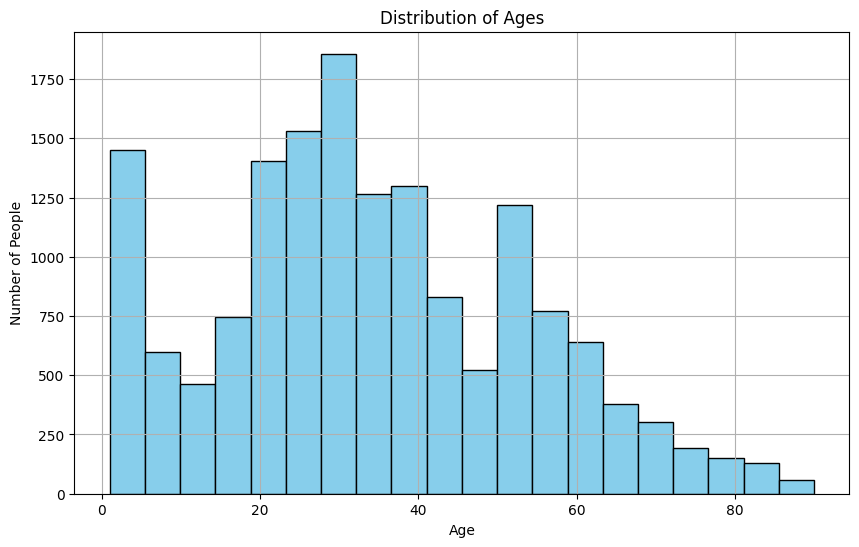

In [ ]:
import matplotlib.pyplot as plt

# Extract ages from the training dataset
ages = train_dataset.ages
print(max(ages))
# Plot the distribution of ages
plt.figure(figsize=(10, 6))
plt.hist(ages, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Ages')
plt.xlabel('Age')
plt.ylabel('Number of People')
plt.grid(True)
plt.show()


In [ ]:
print(train_dataset[0][1])
print(train_dataset[0][0].shape)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


35
torch.Size([3, 224, 224])


In [ ]:
def predict_test(loader, model):
    model.eval()
    predictions = []

    for img in tqdm(loader):
        img = img.to(device)
        pred = model(img)
        predictions.extend(pred.flatten().detach().tolist())

    return predictions



In [ ]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch

# Load pre-trained ResNet-50 model
model = models.wide_resnet50_2( weights='Wide_ResNet50_2_Weights.DEFAULT')

# Unfreeze additional layers for fine-tuning
for name, param in model.named_parameters():
    if "layer3" in name or "layer4" in name or "fc" in name:  # Unfreeze layers
        param.requires_grad = True
    else:
        param.requires_grad = False

# Modify the last layer for age detection task
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),          # Add dropout layer
    nn.Linear(num_ftrs, 512),  # Add additional fully connected layer
    nn.ReLU(),
    nn.Dropout(0.5),           # Add dropout layer
    nn.Linear(512, 1)          # Output 1 value for age prediction
)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

# Use a different learning rate scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # Decrease learning rate every 5 epochs

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Early stopping details
n_epochs_stop = 3
min_val_loss = float('inf')
epochs_no_improve = 0

# Training loop
num_epochs = 12 # Increase epochs to 20
best_model_path='model'
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}")

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs.squeeze(), labels.float()).item() * inputs.size(0)

    val_loss /= len(val_loader.dataset)
    print(f"Validation Loss: {val_loss:.4f}")

    # Step the scheduler
    scheduler.step()

    # Early stopping
    if val_loss < min_val_loss:
        epochs_no_improve = 0
        min_val_loss = val_loss
        torch.save(model,best_model_path)
    else:
        epochs_no_improve += 1
        # Check early stopping condition
        if epochs_no_improve == n_epochs_stop:
            print('Early stopping!')
            break
    # Generate predictions for the test set
    test_predictions = predict_test(test_loader, model)
    print(test_predictions)


Downloading: "https://download.pytorch.org/models/wide_resnet50_2-9ba9bcbe.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-9ba9bcbe.pth
100%|██████████| 263M/263M [00:02<00:00, 97.8MB/s]


Epoch [1/12], Training Loss: 131.1289
Validation Loss: 17.8782


100%|██████████| 31/31 [00:14<00:00,  2.07it/s]


[61.45734786987305, 41.68433380126953, 39.2668342590332, 51.181121826171875, 27.409347534179688, 21.039743423461914, 66.85454559326172, 33.82699203491211, 45.0732536315918, 57.15336990356445, 42.906978607177734, 55.52113342285156, 56.49967575073242, 26.844911575317383, 55.67610168457031, 57.918033599853516, 9.591240882873535, 65.1219711303711, 63.32090759277344, 56.94420623779297, 38.75031661987305, 61.550636291503906, 39.94179153442383, 26.537612915039062, 34.403751373291016, 33.903987884521484, 26.14314842224121, 8.847439765930176, 1.4469032287597656, 22.633975982666016, 38.62885665893555, 54.992393493652344, 6.0221638679504395, 4.123276710510254, 22.542827606201172, 33.270320892333984, 32.548641204833984, 70.90705871582031, 13.808792114257812, 54.433677673339844, 29.86925506591797, 26.42025375366211, 36.71780014038086, 54.266780853271484, 29.299015045166016, 44.523681640625, 30.1960391998291, 29.760208129882812, 16.55144500732422, 42.66791915893555, 41.407588958740234, 54.5954780578

100%|██████████| 31/31 [00:15<00:00,  2.05it/s]


[67.14435577392578, 46.197566986083984, 35.29293441772461, 63.17841720581055, 23.702491760253906, 26.545291900634766, 91.50391387939453, 35.1720085144043, 47.03561782836914, 57.52104568481445, 42.69609069824219, 61.1967658996582, 65.36083984375, 32.684085845947266, 59.187618255615234, 57.73686599731445, 15.79899787902832, 83.29257202148438, 58.236934661865234, 66.59014129638672, 26.046398162841797, 61.409385681152344, 36.09052658081055, 29.0512638092041, 40.87146759033203, 28.675100326538086, 33.312950134277344, 10.406516075134277, 3.6772897243499756, 30.1287899017334, 39.41606903076172, 60.3873291015625, 10.780767440795898, 3.9353373050689697, 25.215803146362305, 31.55189323425293, 29.16582489013672, 65.26368713378906, 7.534565448760986, 47.985877990722656, 29.35749053955078, 30.867942810058594, 39.25991439819336, 60.219688415527344, 26.021583557128906, 45.37130355834961, 27.679561614990234, 36.10857009887695, 25.451108932495117, 48.999717712402344, 33.50263214111328, 58.3835334777832

100%|██████████| 31/31 [00:15<00:00,  2.03it/s]


[67.18164825439453, 45.4177360534668, 34.827144622802734, 52.168155670166016, 25.29136848449707, 28.735280990600586, 100.54657745361328, 42.8997688293457, 54.200645446777344, 76.98186492919922, 45.63889694213867, 73.8433837890625, 81.70162200927734, 36.28731918334961, 69.0285873413086, 60.49761962890625, 17.19415283203125, 90.6773452758789, 74.21629333496094, 65.60803985595703, 35.6096076965332, 69.74153137207031, 39.01274871826172, 32.423458099365234, 40.02418518066406, 30.89210319519043, 34.86247634887695, 11.075260162353516, 1.4930756092071533, 33.772377014160156, 40.25191879272461, 57.852508544921875, 10.186920166015625, 3.283921957015991, 26.366592407226562, 29.980600357055664, 31.70612335205078, 65.07823181152344, 6.768239974975586, 57.31624221801758, 34.24660110473633, 31.093473434448242, 44.689876556396484, 54.22590255737305, 21.62448501586914, 56.71384811401367, 26.906442642211914, 22.31178092956543, 12.965038299560547, 47.107059478759766, 37.950252532958984, 58.5912971496582,

100%|██████████| 31/31 [00:15<00:00,  2.03it/s]


[54.98392868041992, 43.15546798706055, 26.190488815307617, 38.06061553955078, 18.586036682128906, 20.68781852722168, 69.99783325195312, 27.491884231567383, 44.049442291259766, 58.14145278930664, 39.24620819091797, 49.993412017822266, 59.923831939697266, 30.714584350585938, 50.23057556152344, 44.24116897583008, 9.36574935913086, 64.73664855957031, 55.05400085449219, 48.8056755065918, 24.751548767089844, 52.840267181396484, 28.16996192932129, 22.383129119873047, 31.92302131652832, 23.760879516601562, 21.712162017822266, 8.79059886932373, 2.9256591796875, 21.099790573120117, 32.54009246826172, 46.55013656616211, 11.938253402709961, 3.852036476135254, 18.380884170532227, 25.805076599121094, 24.382373809814453, 58.02992630004883, 5.164400100708008, 37.43262481689453, 29.829383850097656, 23.806045532226562, 34.93253707885742, 49.85633850097656, 20.60848617553711, 40.32478332519531, 20.015745162963867, 15.725855827331543, 19.753414154052734, 29.876840591430664, 26.118833541870117, 49.59225845

100%|██████████| 31/31 [00:15<00:00,  2.06it/s]


[57.95237350463867, 47.71902084350586, 27.45705223083496, 67.27914428710938, 22.03824234008789, 26.094972610473633, 90.18495178222656, 34.810691833496094, 46.359642028808594, 71.64863586425781, 44.424442291259766, 61.62775421142578, 71.19750213623047, 30.33485221862793, 68.98944854736328, 55.20579528808594, 12.209137916564941, 80.24081420898438, 65.56262969970703, 65.01657104492188, 31.434412002563477, 57.971031188964844, 45.9996223449707, 27.44948387145996, 39.96631622314453, 33.36375427246094, 29.43790626525879, 6.570601463317871, 3.3340036869049072, 25.636104583740234, 35.02326202392578, 68.79806518554688, 12.153397560119629, 3.736703872680664, 27.066463470458984, 25.279024124145508, 31.967939376831055, 82.16682434082031, 4.135406970977783, 43.13833236694336, 28.01274299621582, 30.589576721191406, 42.2265625, 59.90957260131836, 25.98961067199707, 53.33552169799805, 29.427003860473633, 18.59247589111328, 23.48344612121582, 43.413726806640625, 37.685333251953125, 61.314090728759766, 4

100%|██████████| 31/31 [00:14<00:00,  2.07it/s]


[58.65110397338867, 44.31819534301758, 30.435258865356445, 51.81700134277344, 22.619646072387695, 25.771699905395508, 78.2656478881836, 34.92131805419922, 48.770530700683594, 67.88431549072266, 44.32240295410156, 61.762908935546875, 67.12975311279297, 32.151206970214844, 57.10942840576172, 51.56806182861328, 13.559133529663086, 80.39385223388672, 64.17511749267578, 56.541988372802734, 29.193344116210938, 57.94536209106445, 36.563804626464844, 25.317907333374023, 39.785072326660156, 30.705259323120117, 29.39048957824707, 5.827133655548096, 2.7316079139709473, 24.655351638793945, 34.59284591674805, 58.31974792480469, 11.147133827209473, 3.2914133071899414, 26.48049545288086, 26.213674545288086, 26.017953872680664, 69.20787811279297, 3.309678077697754, 39.0794792175293, 29.24053382873535, 25.417871475219727, 41.592567443847656, 57.05859375, 24.665504455566406, 49.84578323364258, 27.351877212524414, 21.0860652923584, 20.70321273803711, 38.07051467895508, 35.23657989501953, 58.2691764831543

100%|██████████| 31/31 [00:15<00:00,  2.02it/s]


[59.600948333740234, 45.042572021484375, 31.39380645751953, 52.614681243896484, 24.489845275878906, 27.20315170288086, 76.7230224609375, 33.47904968261719, 48.98809814453125, 66.64176940917969, 44.506797790527344, 60.776180267333984, 66.12132263183594, 32.02623748779297, 55.818748474121094, 52.99668884277344, 16.68071746826172, 77.76089477539062, 62.77290344238281, 55.432735443115234, 29.358814239501953, 57.7168083190918, 37.02135467529297, 27.439111709594727, 40.00558853149414, 32.02296447753906, 32.65742874145508, 5.7305192947387695, 3.2110331058502197, 25.922103881835938, 35.5997314453125, 59.820701599121094, 12.09910774230957, 3.1018126010894775, 27.445674896240234, 27.960979461669922, 27.242626190185547, 67.10283660888672, 3.4211299419403076, 39.94304656982422, 28.945106506347656, 25.71536636352539, 43.304595947265625, 55.24553298950195, 25.26004409790039, 50.067134857177734, 26.71699333190918, 19.24627113342285, 21.44392204284668, 39.13311767578125, 35.333335876464844, 57.5923347

100%|██████████| 31/31 [00:15<00:00,  2.02it/s]


[62.3320198059082, 43.74522018432617, 33.63724136352539, 55.99880599975586, 25.07586669921875, 26.455036163330078, 79.83350372314453, 33.80146026611328, 49.33137512207031, 69.24067687988281, 41.091941833496094, 60.81367111206055, 69.6473159790039, 29.954233169555664, 57.10033416748047, 52.92721939086914, 13.224067687988281, 80.89472198486328, 65.11872100830078, 57.09782791137695, 28.512609481811523, 61.112117767333984, 35.865474700927734, 27.46634864807129, 40.20533752441406, 31.23792839050293, 32.207733154296875, 6.916401386260986, 3.2167584896087646, 25.48609733581543, 35.175846099853516, 60.86118698120117, 11.019564628601074, 3.1126739978790283, 28.076353073120117, 25.962610244750977, 29.35158348083496, 69.67591094970703, 3.2496984004974365, 39.34206008911133, 29.237531661987305, 25.405757904052734, 42.79792022705078, 56.33271026611328, 25.04402732849121, 52.165225982666016, 26.48046875, 20.01273536682129, 21.586652755737305, 37.70738220214844, 34.6645622253418, 58.488712310791016, 

100%|██████████| 31/31 [00:15<00:00,  2.05it/s]


[60.48699188232422, 42.40555953979492, 32.490638732910156, 54.149898529052734, 25.456754684448242, 25.038928985595703, 76.33320617675781, 33.66970443725586, 49.7082633972168, 69.70529174804688, 44.77796173095703, 58.921077728271484, 64.86296844482422, 33.05891036987305, 54.161102294921875, 50.6617317199707, 12.844805717468262, 78.78117370605469, 63.53863525390625, 55.46073532104492, 28.034420013427734, 58.414302825927734, 33.98453140258789, 27.650156021118164, 40.22250747680664, 30.717464447021484, 32.366207122802734, 5.457185745239258, 2.7555432319641113, 25.665285110473633, 35.96635055541992, 58.14541244506836, 11.207310676574707, 2.7711198329925537, 27.708974838256836, 27.347461700439453, 29.113021850585938, 66.8753433227539, 2.7554640769958496, 42.64387893676758, 29.925708770751953, 24.745040893554688, 43.88856887817383, 56.09383010864258, 24.7371826171875, 47.74803161621094, 27.607332229614258, 19.64643669128418, 19.834074020385742, 37.1101188659668, 32.500423431396484, 57.6444931

100%|██████████| 31/31 [00:15<00:00,  2.05it/s]


[60.77315902709961, 42.55424880981445, 34.409149169921875, 52.25885009765625, 24.955944061279297, 25.56983184814453, 76.28276062011719, 32.67641067504883, 48.91514587402344, 68.78787231445312, 45.074214935302734, 57.509525299072266, 64.81585693359375, 33.58971405029297, 53.017730712890625, 50.18129348754883, 14.122014999389648, 80.12413024902344, 66.55085754394531, 54.88414764404297, 27.71819305419922, 61.860111236572266, 36.74672317504883, 28.10976791381836, 40.943782806396484, 31.080881118774414, 32.94585037231445, 5.283236503601074, 3.410900831222534, 26.799657821655273, 35.67183303833008, 57.426326751708984, 9.931771278381348, 2.9745099544525146, 27.384672164916992, 28.243139266967773, 31.00391960144043, 65.33018493652344, 3.513336420059204, 40.422611236572266, 29.70707893371582, 26.120647430419922, 42.10385513305664, 57.97555160522461, 25.568862915039062, 47.717979431152344, 27.60654067993164, 20.062442779541016, 19.295589447021484, 38.47975540161133, 32.513092041015625, 58.518100

100%|██████████| 31/31 [00:15<00:00,  2.05it/s]


[61.240257263183594, 42.40212631225586, 33.38633346557617, 53.739803314208984, 24.6597957611084, 25.846181869506836, 77.83637237548828, 32.55211639404297, 48.61518096923828, 68.82074737548828, 43.95748519897461, 57.668434143066406, 65.59819793701172, 32.39962387084961, 53.88343048095703, 50.70836639404297, 14.268083572387695, 80.2059326171875, 66.29344177246094, 55.19224548339844, 27.873857498168945, 61.460105895996094, 36.3704719543457, 27.858558654785156, 40.41745376586914, 30.737865447998047, 32.57807159423828, 6.181025505065918, 3.7778689861297607, 26.6201171875, 35.62358093261719, 58.51970672607422, 10.715032577514648, 3.296910047531128, 27.230043411254883, 27.521642684936523, 29.668594360351562, 66.4515380859375, 3.64971661567688, 39.751136779785156, 29.38943862915039, 25.807147979736328, 42.05816650390625, 57.886749267578125, 24.985828399658203, 48.286190032958984, 27.6376953125, 20.308490753173828, 19.625164031982422, 38.49766540527344, 32.18486404418945, 58.404396057128906, 37

100%|██████████| 31/31 [00:15<00:00,  2.06it/s]

[61.71122741699219, 42.1777458190918, 33.58103561401367, 54.97988510131836, 24.609594345092773, 25.46404457092285, 78.56416320800781, 33.04578399658203, 48.92485427856445, 70.29082489013672, 43.53771209716797, 57.973941802978516, 65.8343505859375, 31.97309684753418, 54.74552536010742, 50.71816635131836, 12.715953826904297, 81.06571960449219, 66.0969467163086, 55.861690521240234, 27.741439819335938, 61.627925872802734, 36.5870475769043, 27.6173038482666, 40.6505241394043, 30.58402442932129, 32.51150131225586, 5.07885217666626, 3.0303945541381836, 26.458547592163086, 36.82766342163086, 59.48988723754883, 10.207878112792969, 3.0031399726867676, 26.89803123474121, 27.01173210144043, 29.860074996948242, 67.97459411621094, 3.0019712448120117, 40.328250885009766, 29.27789878845215, 25.36524772644043, 42.341617584228516, 58.200870513916016, 24.468420028686523, 49.008827209472656, 27.25960350036621, 20.054122924804688, 18.775341033935547, 38.28532028198242, 31.958398818969727, 58.29805374145508

In [ ]:
import pandas as pd
from tqdm import tqdm

# Function to predict ages for the test set
def predict_test(loader, model):
    model.eval()
    predictions = []

    for img in tqdm(loader):
        img = img.to(device)
        pred = model(img)
        predictions.extend(pred.flatten().detach().tolist())

    return predictions

# Generate predictions for the test set
test_predictions = predict_test(test_loader, model)

# Round predictions to nearest integer
rounded_predictions = [round(pred) for pred in test_predictions]

# Load the submission file template
submission_template = pd.read_csv('/content/SMAI/content/faces_dataset/submission.csv')

# Update the age column with predictions
submission_template['age'] = rounded_predictions

# Save the submission file
submission_template.to_csv('submission.csv', index=False)


100%|██████████| 31/31 [00:19<00:00,  1.62it/s]


In [ ]:
print(rounded_predictions)

[62, 42, 34, 55, 25, 25, 79, 33, 49, 70, 44, 58, 66, 32, 55, 51, 13, 81, 66, 56, 28, 62, 37, 28, 41, 31, 33, 5, 3, 26, 37, 59, 10, 3, 27, 27, 30, 68, 3, 40, 29, 25, 42, 58, 24, 49, 27, 20, 19, 38, 32, 58, 37, 44, 22, 45, 64, 2, 29, 48, 62, 35, 71, 66, 79, 28, 23, 31, 11, 53, 64, 30, 45, 65, 20, 59, 26, 60, 63, 53, 42, 78, 58, 18, 2, 31, 57, 55, 17, 22, 66, 39, 28, 29, 23, 24, 56, 55, 54, 76, 53, 31, 32, 19, 27, 35, 56, 57, 41, 21, 22, 20, 42, 28, 5, 55, 3, 56, 28, 29, 26, 26, 14, 57, 31, 13, 39, 48, 63, 50, 23, 41, 62, 25, 26, 23, 27, 48, 33, 58, 77, 19, 37, 54, 71, 32, 66, 22, 47, 22, 52, 4, 48, 30, 85, 22, 37, 24, 30, 21, 47, 33, 62, 59, 39, 34, 21, 53, 64, 21, 51, 25, 54, 32, 37, 4, 14, 43, 27, 2, 13, 28, 28, 6, 95, 50, 61, 60, 22, 12, 8, 10, 5, 9, 47, 69, 57, 10, 89, 48, 4, 40, 71, 34, 31, 30, 60, 32, 41, 40, 8, 20, 18, 50, 54, 6, 38, 66, 31, 28, 11, 19, 12, 57, 54, 32, 67, 45, 30, 48, 35, 3, 49, 49, 45, 33, 23, 22, 65, 61, 68, 38, 62, 8, 3, 66, 52, 29, 24, 57, 59, 82, 2, 77, 39, 3